David Regev
204813323

# Glioblastoma

## import and preperation of the data

In [2]:
import lifelines as ll
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from lifelines.statistics import logrank_test
%matplotlib inline

In [3]:
gl = pd.read_csv('data.csv')
gl['Race'] = gl['Race'].str.strip()
gl['Gender'] = gl['Gender'].str.strip()
gl['Life'] = gl['Life'].replace('Dead', 1)
ohe_gl = pd.get_dummies(gl, columns=['Race', 'Gender'])

## Is there a gene that statistically significantly testifies the aggresivity of GBM?
There are 500 hypotheses that we want to check.<br>
In each one the assumption is that a gene is not significant for the agrresiveness of GBM.

## log-rank test
We use log-rank test to compare a gene with and without mutatuion survival function curves

In [3]:
genes = ohe_gl.columns.drop(['ID', 'Age at Diagnosis ', 'Life', 'Days Till Death', 'Race_African American', 'Race_Asian', 'Race_Caucasian', 'Gender_Male', 'Gender_Female'])
p_values = {}
for gene in genes:
    yes_gene = ohe_gl[ohe_gl[gene] == 1]
    no_gene = ohe_gl[ohe_gl[gene] == 0]

    results = logrank_test(yes_gene['Days Till Death'], no_gene['Days Till Death'], yes_gene['Life'], no_gene['Life'])
    p_values[gene] = results.summary['p']

## As we have multiple hypotheses, we need to perform a correction on the p-values.
We perform three of them:<br>
1. Boneforni.<br>
2. Holm.<br>
3. FDR.

## Boneforni-Correction

In [4]:
boneforni_p_values = p_values.copy()
boneforni_p_values = {k: v * len(boneforni_p_values) for k, v in boneforni_p_values.items()}
significants = [k for k, v in boneforni_p_values.items() if v.item() < 0.05]
print(significants)

['NLRP4']


## Holm-Correction

In [5]:
holm_p_values = p_values.copy()
holm_p_values = {k: v for k, v in sorted(p_values.items(), key=lambda item: item[1].item())}

holm_correction_p_values = {}
m = len(holm_p_values)
for gene in holm_p_values:
    holm_correction_p_values[gene] = m * holm_p_values[gene]
    m -= 1
    
significants = [k for k, v in holm_correction_p_values.items() if v.item() < 0.05]
print(significants)

['NLRP4']


### FDR

In [6]:
fdr_p_values = p_values.copy()
fdr_p_values = {k: v for k, v in sorted(p_values.items(), key=lambda item: item[1].item())}

fdr_correction_p_values = {}
index = 1
m = len(fdr_p_values)
for gene in fdr_p_values:
    fdr_correction_p_values[gene] = (m * fdr_p_values[gene]) / index
    index += 1
print([k for k, v in fdr_correction_p_values.items() if v.item() < 0.05])

['NLRP4']


## Conclusion
In the three corrections the result is that only the gene <b>'NLRP4'</b> is significant<br>
and therefore we consider it as a gene that indicates agrresiveness of GBM.<br>

### There is no group of genes with low FDR for a model

In the graph below we can see the significant of the gene,<br>
a mutation in that gene shrply affects the survival function,<br>
and decreases life in about 400 days in average.

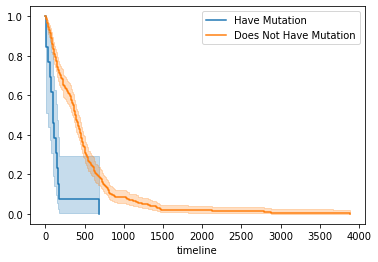

In [7]:
km = ll.KaplanMeierFitter()
yes_gene = ohe_gl[ohe_gl['NLRP4'] == 1]
no_gene = ohe_gl[ohe_gl['NLRP4'] == 0]

x = km.fit(yes_gene['Days Till Death'], yes_gene['Life']).plot(label='Have Mutation')
y = km.fit(no_gene['Days Till Death'], no_gene['Life']).plot(label='Does Not Have Mutation')

results = logrank_test(yes_gene['Days Till Death'], no_gene['Days Till Death'], yes_gene['Life'], no_gene['Life'])

## Finding the six most significant genes for the Cox model

In [8]:
i = 0
genes = []
for gene in fdr_correction_p_values:
    genes.append(gene)
    i += 1
    if i == 6:
        break

# Is demographic based model better then gene based models?
in order to check this we use Cox test to check if there is another significant<br>
feature that indicates the agrresivenes of GBM<br>

The null hypothesis is that the demographic model isn't better than the genes models.

## Cox test for demographic data

### Model with race and gender

In [4]:
cph = ll.CoxPHFitter()
gen_gl = ohe_gl[['Life', 'Days Till Death', 'Age at Diagnosis ', 'Race_Caucasian', 'Race_African American', 'Gender_Male', 'NLRP4', 'ITGAD', 'IDH1', 'CALN1', 'MAGI1', 'ITGB4']]
cph.fit(gen_gl, duration_col='Days Till Death', event_col='Life')
cph.print_summary()

### Now we build 6 models each for specific gene and compare the results

In [10]:
for gene in genes:
    gen_gl = ohe_gl[['Life', 'Days Till Death', gene]]
    cph.fit(gen_gl, duration_col='Days Till Death', event_col='Life')
    cph.print_summary()

## Conclusion
In the demographic based model we found that the age at diagnosis is significant either.<br>
Although in that model not all the genes were significant and in their model they were,<br>
the genes' models have C-index somewhat about 0.5 that is very close to random predictions<br>
while the demographic model has C-index of 0.6 that is much better in comparison.<br><br>

On the other hand, the log-likelihood of the demographic model is much higher than the gene models'<br>
log-likelihood so it seems that the null hypothesis isn't rejected<br> (as far as I understood from the internet, if I am wrong the null hypothesis is rejected and please ignore).

## Addition
When I use cox model to find the 6 most significant genes I get: NLRP4, ITGAD, ADAMTS12, PRUNE2, TP53, TACC2
The conclusion although doesn't change.

In [11]:
genes = ohe_gl.columns.drop(['ID', 'Age at Diagnosis ', 'Life', 'Days Till Death', 'Race_African American', 'Race_Asian', 'Race_Caucasian', 'Gender_Male', 'Gender_Female'])
p_values = {}
for gene in genes:
    gen_gl = ohe_gl[['Age at Diagnosis ', 'Life', 'Days Till Death', 'Race_African American', 'Race_Asian', 'Gender_Female', gene]]
    cph.fit(gen_gl, duration_col='Days Till Death', event_col='Life')
    p_values[gene] = cph.summary['p'][gene]

fdr_p_values = p_values.copy()
fdr_p_values = {k: v for k, v in sorted(p_values.items(), key=lambda item: item[1].item())}

fdr_correction_p_values = {}
index = 1
m = len(fdr_p_values)
for gene in fdr_p_values:
    fdr_correction_p_values[gene] = m * fdr_p_values[gene]
    index += 1
print([k for k, v in fdr_correction_p_values.items() if v.item() < 0.05])

i = 0
genes = []
for gene in fdr_correction_p_values:
    genes.append(gene)
    i += 1
    if i == 6:
        break

['NLRP4']


In [12]:
gen_gl = ohe_gl[['Life', 'Days Till Death', 'Race_Caucasian', 'Race_African American', 'Gender_Male', 'NLRP4', 'ADAMTS12', 'ITGAD', 'PRUNE2', 'TP53', 'TACC2']]
cph.fit(gen_gl, duration_col='Days Till Death', event_col='Life')
cph.print_summary()

In [13]:
for gene in genes:
    gen_gl = ohe_gl[['Life', 'Days Till Death', gene]]
    cph.fit(gen_gl, duration_col='Days Till Death', event_col='Life')
    cph.print_summary()